In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, desc, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
Measurement

sqlalchemy.ext.automap.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
query = 'SELECT * FROM measurement'
measurement_df = pd.read_sql(query, engine)
##measurement_df = pd.DataFrame(session.query(Measurement).all())
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


# Exploratory Precipitation Analysis

In [32]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()
recent_date = recent_date[0]
recent_date = dt.datetime.strptime(recent_date, "%Y-%m-%d").date()
recent_date
beginning_date = session.query(Measurement.date).order_by(Measurement.date).first()
beginning_date = beginning_date[0]
beginning_date

'2010-01-01'

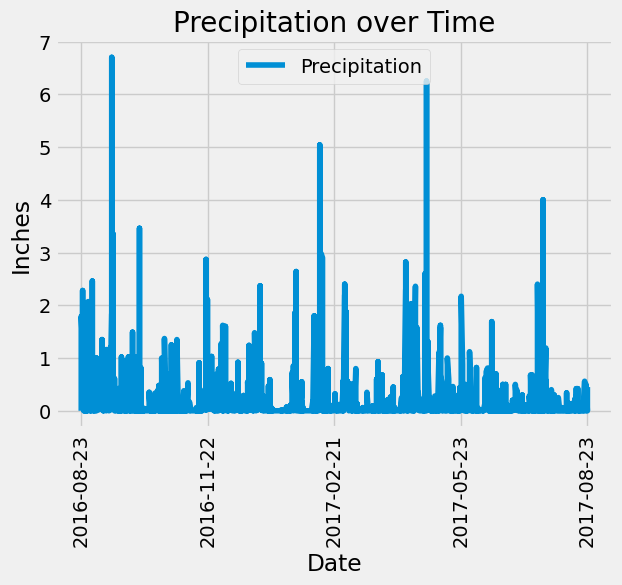

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
query_date = recent_date - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores

query = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= query_date).\
    filter(Measurement.date <= recent_date).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
query
query_df = pd.DataFrame({'Date': [dt.datetime.strptime(i.date, "%Y-%m-%d").date() for i in query],
                         'Precipitation': [i.prcp for i in query]})

# Sort the dataframe by date
query_df.dropna(inplace=True)
query_df = query_df.sort_values(['Date'],ascending = True).set_index(['Date'])
#query_df.drop('index', axis=1, inplace=True)
query_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
ax = query_df.plot(kind = 'line')
# Set the number of x-ticks to 5 and include the start and end
ticks = pd.date_range(start=query_date, end=recent_date, periods=5)

# Set the x-tick positions manually
ax.set_xticks(ticks)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation over Time')
plt.legend(loc='upper center')
plt.xticks(rotation=90)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = query_df.describe() 
summary

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [31]:
# Design a query to calculate the total number of stations in the dataset
station_count1 = session.query(Measurement.station,Measurement.prcp).group_by(Measurement.station).count()

station_count2 = session.query(Station).count()
station_count2

print(station_count1 == station_count2)
station = session.query(Station.station).all()
station
query = session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).all()
query
results = [round(i,2) for i in query[0]]
results

True


[53.0, 73.1, 87.0]

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.prcp)).group_by(Measurement.station).order_by(desc(func.count(Measurement.prcp))).all()
most_active_station = active_stations[0][0]
active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mas_stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == most_active_station).group_by(Measurement.station).all()
mas_stats

[(54.0, 85.0, 71.66378066378067)]

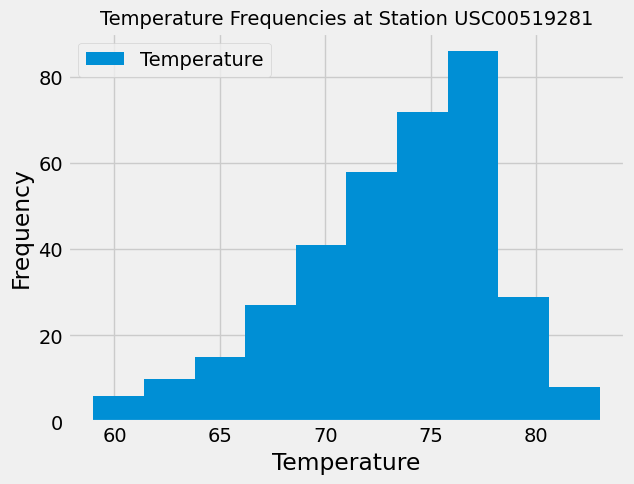

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(Measurement.tobs).\
    filter(Measurement.date >= query_date).\
    filter(Measurement.date <= recent_date).filter(Measurement.station == most_active_station).all()
query
query_df = pd.DataFrame({'Temperature': [i.tobs for i in query]})
query_df.plot(kind = 'hist')
plt.xlabel('Temperature')
plt.title(f'Temperature Frequencies at Station {most_active_station}',fontsize = 14)
plt.legend(loc='upper left')
plt.show()

# Close Session

In [18]:
# Close Session
session.close()